### Generate Grayscale Handwritten Digits using Generative Adversarial Networks (GANs)

In [1]:
!nvidia-smi

Sat Apr  8 07:12:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [3]:
# visualization
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor dimension : 128 * 784
  data = tensor.detach().cpu().view(-1,ch,*size) # re-shaping the tensor to -> 128 * 1 * 28 * 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # nrows=4, making grid 4 * 4 because we are considering 16 images only . 
  # Changing the order of the image channel to display in matplotlib -> 1 * 28 * 28 = 28 * 28 * 1 . Changing it to Width * Height * Channel. Order of the image is diff in Pytorch and Matplotlib
  plt.imshow(grid)
  plt.show()


In [4]:
from torch.nn.modules import transformer
# set up the parameters and Hyperparameters
epochs = 400
cur_step = 0
info_step = 300

mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

batch_size = 128

device = 'cuda'

# Number of steps = 60000(total images in MNIST dataset) / 128

dataloader = DataLoader(MNIST('.',download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=batch_size)


100%|██████████| 9912422/9912422 [00:00<00:00, 72971977.56it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105610892.61it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69873722.14it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17737922.50it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# declare the models

# Generator

def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64,i_dim=784,h_dim=784):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128",
        genBlock(h_dim, h_dim*2), # 128, 256",
        genBlock(h_dim*2, h_dim*4), # 256 x 512",
        genBlock(h_dim*4, h_dim*8), # 512, 1024",
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)",
        nn.Sigmoid(),
    )

  def forward(self,noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)


## Discriminator

def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
     super().__init__(),
     self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024"
        discBlock(h_dim*4, h_dim*2), # 1024, 512",
        discBlock(h_dim*2, h_dim), # 512, 256",
        nn.Linear(h_dim, 1) # 256, 1",
        )

  def forward(self, image):
      return self.disc(image)



In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [6]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=784, bias=True)
      (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=784, out_features=1568, bias=True)
      (1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=1568, out_features=3136, bias=True)
      (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=3136, out_features=6272, bias=True)
      (1): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=6272, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [7]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([6, 1, 0, 7, 4, 5, 6, 0, 7, 9])


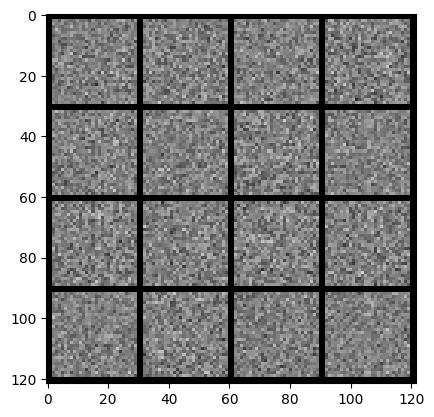

In [8]:
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [9]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func,gen,disc,batch_size,input_dimension):
  noise = gen_noise(batch_size,input_dimension)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred,targets)
  return gen_loss

# discriminator loss
def calc_disc_loss(loss_func,gen,disc,batch_size,real_output,input_dimension):
  noise = gen_noise(batch_size,input_dimension)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake,disc_fake_targets)


  disc_real = disc(real_output)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real,disc_real_targets)

  disc_loss = (disc_fake_loss + disc_real_loss)/2

  return disc_loss


In [ ]:
### 60000 / 128 = 468.75  = 469 steps in each epoch"
### Each step is going to process 128 images = size of the batch (except the last step)"

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator"
    disc_opt.zero_grad()

    curr_batch_size = len(real) # all batches except last one : 128 x 1 x 28 x 28
    real = real.view(curr_batch_size, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,curr_batch_size,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,curr_batch_size,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(curr_batch_size, z_dim)
      fake = gen(fake_noise)
      show(fake)

      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1




  0%|          | 0/469 [00:00<?, ?it/s]